In [1]:
import matlab.engine
import numpy as np
import scipy.optimize

# Trial and pd parameters

In [52]:
# trial and adherence information
drug = "ATV/r"

days = np.double(40) #days to run trial for
increment = 0.01 # days between each timepoint returned
prob_adh = 0.5 if drug != 'TEST' else 0. # probability of taking each pill (independent)
adh_pat = 0 # 0 = random prob for each dose, 1 = random prob each day after missed dose
adh_shuff = np.double(0.) # standard deviation in the time of taking a pill vs scheduled (days)
trial_type = 1 # 1 = suppression trial, 0=maintenance trial
burnin = 7*5 # days before interval sampling begins in maintenance trials
sampling_int = 28 # days between each sampling time in maintenance trials
threshold = 200 # threshold viral load above which failure is declared
mut_frac = 0.2 # threshold fraction of population of mutant above which declared failure via resistance

## Use existing matlab scripts to calculate concentration(t)

In [2]:
eng = matlab.engine.start_matlab()
eng.cd(r'~/develop/withinhostHIV/MatlabCode/', nargout=0)
eng.eval("addpath('Parameters','Utilities')", nargout=0)

In [53]:
eng.workspace["drug"] = drug
trial, pd = eng.trial_setup(eng.eval("drug"), days, increment, prob_adh, adh_pat, adh_shuff, trial_type, burnin, sampling_int, threshold, mut_frac, nargout=2)
eng.workspace["trial"] = trial
eng.workspace["pd"] = pd

In [54]:
dose_t, _ = eng.adh_trajectory(eng.eval("pd.num_doses"), trial, nargout=2)

In [55]:
c_vec,inhib_vec = eng.drug_trajectory(pd, trial, dose_t, nargout=2)

## Use existing matlab scripts to calculate mutation matrix Q

In [56]:
smin=0.05; #highest mutant fitness
smax=0.9; #lowest mutant fitness
smiss=0.05; #fitness of strains with missing cost
rfmiss=1; #fold change in resistance for strains with it missing
mfmiss=0; #fractional change in slope for strains with it missing
back_mutation_on = drug != 'TEST' #include(1) or exclude(0) back mutation
direct_multi_hit = drug != 'TEST' #include(1) or exclude(0) direct multi-hit mutations from WT
direct_multi_multi = drug != 'TEST' #include(1) or exclude(0) direct multi-hit mutations from one res strain to another

In [57]:
mparams,Q = eng.getMutInfo(drug,smin,smax,smiss,rfmiss,mfmiss,back_mutation_on,direct_multi_hit,direct_multi_multi,nargout=2);
eng.workspace["Q"] = Q
Q = eng.eval("Q{:,:};") # get a matrix instead of a matlab table

## Viral dynamics parameters

In [58]:
R00 = 10.0 # average number of new virions produced by infection with a single virion === average number of new infected cells produced by 1 infected cell
fbp = 0.55 # fraction of blood that is plasma
Vpl = 3*10e3 # volume of plasma in mL
ftcell_pl = 0.02 # fraction of T cells that are circulating in blood (vs in lymph system)
hl_lr = 44*30.5 # half life of decay of latent reservoir, days
A = 100 # total reactivation of latent cells per day
#### TODO CHECK CHECK CHECK SCIENTIFIC NOTATION
flr = 1e-6# fraction of CD4 T cells that are latently infected at equilibrium

scale_cd4_body = (Vpl*10**3)/(fbp*ftcell_pl) # factor to go from T cell per ul blood to whole body

fa = 0.01 # fraction of infected CD4 cells that support productive vs abortive infection
dx = 0.05 # death rate of uninfected cells (per day) and by assumption dx == d, rate of death without viral cytolytic effects
L = scale_cd4_body*1000*dx # uninfected cells produced per day (/ul)
a = A/(flr*L/dx) # rate of exit of latent cells (per day)
dz = np.log(2)/(hl_lr)-a # death rate of latently infected cells (per day)

dy = 1 # TOTAL death rate of infected cells (per day) (=death due to burst (k) + death without viral cytolytic effects)
k = dy-dx # rate of death+emission of a burst of virions (per day)
# CHECK SCI NOTO
N = 2.38e5
assert(N > R00);

# probability of a single virion establishing infection, solved implicitly
p_est_solution = scipy.optimize.least_squares(lambda p_est: R00*(1-(1-p_est)**N) - N*p_est, 0.1)
assert(p_est_solution.success)
p_est = p_est_solution.x

dv = 25 # TOTAL death rate of virions (per day)
beta = R00 * dy * dv * dx / (k * N * fa * L) # infectivity rate (per day*infectious-target cell pair)
c = dv-beta*L/dx # clearance rate of virions (per day);
assert(c > 0)
g = flr*dy/dx*(a+dz)/(fa*(1-1/R00)) # fraction of new infections that become latent

In [59]:
# Access matlab parameters
eng.workspace["mparams"] = mparams
IC50 = eng.eval('pd.IC50')
m = eng.eval('pd.m')
cost = eng.eval('mparams.cost')
rf = eng.eval('mparams.rf')
mf = eng.eval('mparams.mf')
t_vec = eng.eval('(0:trial.increment:trial.days);')

## Check beta (from matlab) against beta (from python)

In [ ]:
beta_t, beta_u_t = eng.calculate_beta_of_t(t_vec, beta, c_vec, IC50, m, cost, rf, mf, eng.eval('height(mparams)'), nargout=2)

In [60]:
def calculate_beta_t(beta_0, concentration, IC50, m, cost, rf, mf):
    # B/[cost * (1 + concentration)/(IC50*rf)^(m*(1+mf))]
    B = beta_0
    denominator = cost * (1 + (concentration/(IC50*rf))**(m*(1+mf)))
    return B/denominator


# make sure we didn't mess up our function definition
assert(np.allclose(calculate_beta_t(beta, np.asarray(c_vec), IC50, m, np.asarray(cost).T, np.asarray(rf).T, np.asarray(mf).T), np.asarray(beta_u_t)))
assert(np.allclose(calculate_beta_t(beta, np.asarray(c_vec), IC50, m, 1, 1, 1), np.asarray(beta_t)))

beta_u_t = calculate_beta_t(beta, np.asarray(c_vec), IC50, m, np.asarray(cost).T, np.asarray(rf).T, np.asarray(mf).T)
beta_t   = calculate_beta_t(beta, np.asarray(c_vec), IC50, m, 1, 1, 1)

beta_t = np.concatenate([beta_t, beta_u_t], axis=1)
t_vec = np.asarray(t_vec).squeeze()
dose_t = np.asarray(dose_t).T.squeeze()

In [64]:
sampled_concentration = np.asarray(c_vec)
# closed around parameters
# pulls the nearest beta pre-calculated to the left of the current time
def discrete_beta_of_t(t):
    # last time where beta was precalculated *before* t
    t_left_index = np.searchsorted(t_vec, t) - 1
    if t_left_index < 0:
        if t_left_index == -1:
            t_left_index = 0
        else:
            raise ValueError()
    return beta_t[t_left_index]

def force_of_infection(t):
    beta = discrete_beta_of_t(t)
    return (np.expand_dims(beta,1) * fa * Q).flatten()

TODO: triple check to make sure this is the right orientation of beta_i relative to Q

In [61]:
Q = np.asarray(Q)
Q

array([[1.00000000e+00, 9.31401597e-07, 1.15302567e-05, 1.15302033e-05],
       [6.38285140e-06, 1.00000000e+00, 7.35959154e-11, 7.35955744e-11],
       [4.29936191e-05, 4.00443255e-11, 1.00000000e+00, 4.95725170e-10],
       [2.62179380e-05, 2.44194294e-11, 3.02299557e-10, 1.00000000e+00]])

In [62]:
np.expand_dims(beta_t[0],1)

array([[5.72353685e-29],
       [1.80640339e-19],
       [3.44853164e-20],
       [1.34826435e-18]])

# Define model

In [110]:
import reactions
num_strains = beta_t.shape[1]
num_strains

4

In [111]:
ys = [reactions.Species(f'infected cells strain {i}', f'y{i}') for i in range(num_strains)]
zs = [reactions.Species(f'latent cells strain {i}', f'z{i}') for i in range(num_strains)]
vs = [reactions.Species(f'viruses strain {i}', f'v{i}') for i in range(num_strains)]
x = reactions.Species("target cells", "x")
all_species = [x] + ys + vs + zs

In [112]:
target_cell_birth = reactions.Reaction("target cell birth", [], [x], k=L)
target_cell_death = reactions.Reaction("target cell death", [x], [], k=dx)
infected_death = [reactions.Reaction(f"death of infected cell strain {i}", [ys[i]], [], k=(dy-k)) for i in range(num_strains)]
infected_cell_burst = [reactions.Reaction(f"burst of infected cell strain {i}", [ys[i]], [(vs[i], N)], k=k) for i in range(num_strains)]
into_latency = [reactions.Reaction(f"strain {i} --> latency", [ys[i]], [zs[i]], k=g) for i in range(num_strains)]
out_of_latency = [reactions.Reaction(f"latent --> strain {i}", [zs[i]], [ys[i]], k=a) for i in range(num_strains)]
death_of_latent = [reactions.Reaction(f"latent {i} death", [zs[i]], [], k=dz) for i in range(num_strains)]
viral_clearance = [reactions.Reaction(f"clearance of strain {i} virion", [vs[i]], [], k=c) for i in range(num_strains)]

infections = []
for j in range(num_strains):
    for i in range(num_strains):
        infections.append(reactions.Reaction(f"infection of x by {i}->{j}", [x, vs[i]], [ys[j]]))
infection_family = reactions.ReactionRateFamily(infections, k=force_of_infection)

all_reactions = [target_cell_birth, target_cell_death] + infected_death + infected_cell_burst + into_latency + out_of_latency + death_of_latent + viral_clearance + [infection_family]


In [113]:
model = reactions.Model(all_species, all_reactions)

In [114]:
print(model.pretty(skip_blanks=True))

target cell birth     :  0  -->  1x 
target cell death     : 1x  -->   0 
death of infected cell:   1y0 -->   0 
death of infected cell:   1y1 -->   0 
death of infected cell:   1y2 -->   0 
death of infected cell:   1y3 -->   0 
burst of infected cell:   1y0 -->   >9v0
burst of infected cell:   1y1 -->   >9v1
burst of infected cell:   1y2 -->   >9v2
burst of infected cell:   1y3 -->   >9v3
strain 0 --> latency  :   1y0 -->    1z0
strain 1 --> latency  :   1y1 -->    1z1
strain 2 --> latency  :   1y2 -->    1z2
strain 3 --> latency  :   1y3 -->    1z3
latent --> strain 0   :   1z0 -->    1y0
latent --> strain 1   :   1z1 -->    1y1
latent --> strain 2   :   1z2 -->    1y2
latent --> strain 3   :   1z3 -->    1y3
latent 0 death        :   1z0 -->   0 
latent 1 death        :   1z1 -->   0 
latent 2 death        :   1z2 -->   0 
latent 3 death        :   1z3 -->   0 
clearance of strain 0 :   1v0 -->   0 
clearance of strain 1 :   1v1 -->   0 
clearance of strain 2 :   1v2 -->   0 
clear

# Run forward simulation

In [71]:
import hybrid

In [109]:
%%timeit
rng = np.random.default_rng()

extra_discontinuities = list(np.linspace(0.0,40.0,400))
extra_discontinuities = []

y0 = np.zeros(len(all_species))
y0[model.species_index[x]] = L/dx/R00
y0[model.species_index[ys[0]]] = fa*(1-1/R00)*L/dy
y0[model.species_index[zs[0]]] = y0[model.species_index[ys[0]]]*g/(a+dz)
result = hybrid.forward_time(
    y0,
    [0, 40.0],
    lambda p: hybrid.partition_by_threshold(p, 100),
    model.k,
    model.stoichiometry(),
    model.rate_involvement(),
    rng,
    discontinuities=np.sort(np.array(list(dose_t)+extra_discontinuities))
)
result

Jumping from 3.9999999999 to 4.000000000000001 to avoid discontinuity
Jumping from 5.9999999999 to 6.000000000000001 to avoid discontinuity
Jumping from 7.9999999999 to 8.000000000000002 to avoid discontinuity
Jumping from 11.9999999999 to 12.000000000000002 to avoid discontinuity
Jumping from 14.9999999999 to 15.000000000000002 to avoid discontinuity
Jumping from 15.9999999999 to 16.000000000000004 to avoid discontinuity
Jumping from 16.9999999999 to 17.000000000000004 to avoid discontinuity
Jumping from 17.9999999999 to 18.000000000000004 to avoid discontinuity
Jumping from 19.9999999999 to 20.000000000000004 to avoid discontinuity
Jumping from 20.9999999999 to 21.000000000000004 to avoid discontinuity
Jumping from 22.9999999999 to 23.000000000000004 to avoid discontinuity
Jumping from 25.9999999999 to 26.000000000000004 to avoid discontinuity
Jumping from 26.9999999999 to 27.000000000000004 to avoid discontinuity
Jumping from 27.9999999999 to 28.000000000000004 to avoid discontinuit

In [99]:
prop = hybrid.calculate_propensities(y0, model.k(0), model.rate_involvement())
y0_expanded = np.zeros(len(y0)+1)
y0_expanded[:-1] = y0
hybrid.dydt(0, y0_expanded, model.k, model.stoichiometry(), model.rate_involvement(), hybrid.partition_by_threshold(prop, 0), 0)

array([ 1.22727273e+11, -1.22727404e+09,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.77486364e+14,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.42108547e-14,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [100]:
model.species

[Species(name=target cells, abbreviation=x),
 Species(name=infected cells strain 0, abbreviation=y0),
 Species(name=infected cells strain 1, abbreviation=y1),
 Species(name=infected cells strain 2, abbreviation=y2),
 Species(name=infected cells strain 3, abbreviation=y3),
 Species(name=viruses strain 0, abbreviation=v0),
 Species(name=viruses strain 1, abbreviation=v1),
 Species(name=viruses strain 2, abbreviation=v2),
 Species(name=viruses strain 3, abbreviation=v3),
 Species(name=latent cells strain 0, abbreviation=z0),
 Species(name=latent cells strain 1, abbreviation=z1),
 Species(name=latent cells strain 2, abbreviation=z2),
 Species(name=latent cells strain 3, abbreviation=z3)]

In [101]:
scale_cd4_body=(Vpl*10**3)/(fbp*ftcell_pl)
#scale_cd4_virus=kdv*2*1e3/fbp

(1e-07, 1000.0)

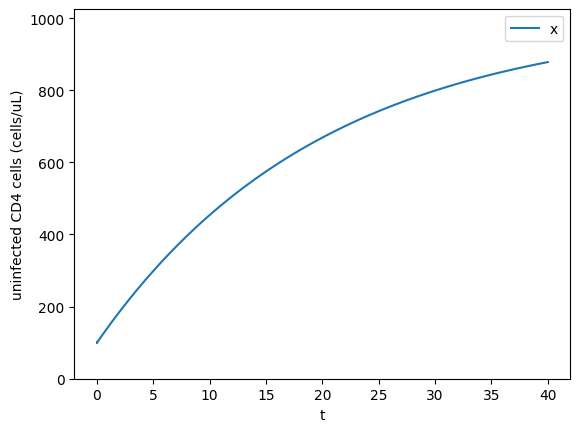

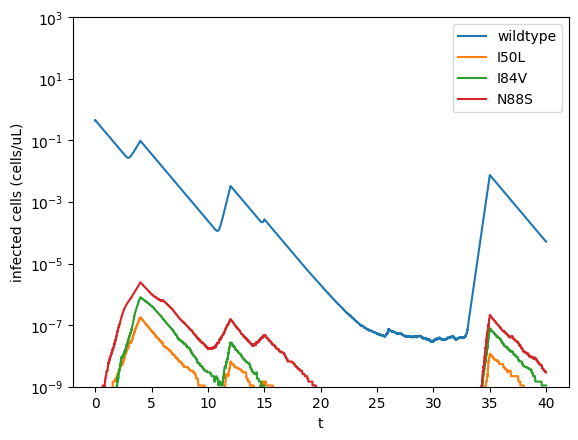

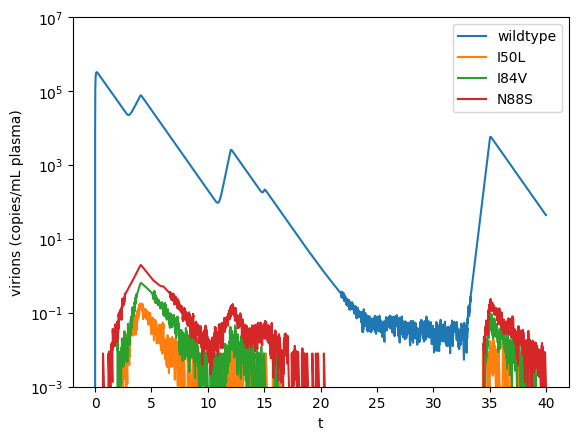

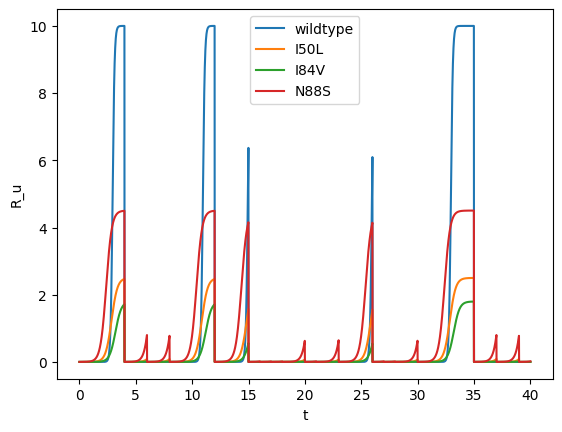

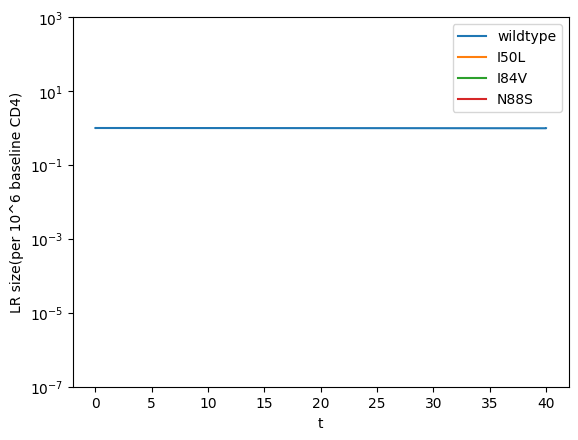

In [105]:
mnames = list(np.asarray(eng.eval('mparams.Properties.RowNames')))

import matplotlib.pyplot as plt
plt.figure()
plt.plot(result.t_history, result.y_history[0].T/scale_cd4_body, label='x')
plt.yscale('linear')
plt.ylabel('uninfected CD4 cells (cells/uL)')
plt.xlabel('t')
plt.legend()
plt.ylim([0, 1025])

plt.figure()
plt.plot(result.t_history, result.y_history[1:1+len(ys)].T/scale_cd4_body, label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('infected cells (cells/uL)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-9, 1e3])

plt.figure()
plt.plot(result.t_history, result.y_history[model.species.index(vs[0]):model.species.index(vs[-1])+1].T/Vpl/1000, label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('virions (copies/mL plasma)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-3, 1e7])

plt.figure()
plt.plot(t_vec, beta_t*R00/beta, label=['wildtype']+mnames)
plt.legend()
plt.ylabel('R_u')
plt.xlabel('t')
plt.yscale('linear')

plt.figure()
plt.plot(result.t_history, result.y_history[model.species.index(zs[0]):model.species.index(zs[-1])+1].T*(10**6)/(L/dx), label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('LR size(per 10^6 baseline CD4)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-7, 10e2])

In [104]:
result.y_history[model.species.index(zs[0]):model.species.index(zs[-1])+1][:,-1]/(10**6)/(L/dx)

array([9.84604133e-13, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])